In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

In [2]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    # df.index = pd.to_datetime(df.index)

    return df

In [3]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

In [23]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [19]:
folder = Path('../data')
prices_original = read_dataset(folder, file='prices_original.csv', date_col=0)
apple_original = prices_original.loc[prices_original['ticker'] == 'AAPL'][['close']]

prices_missing = read_dataset(folder, file='prices_missing.csv', date_col=0)
apple_missing = prices_missing.loc[prices_missing['ticker'] == 'AAPL'][['close']]

In [22]:
apple_missing.isnull().sum()

close    22
dtype: int64

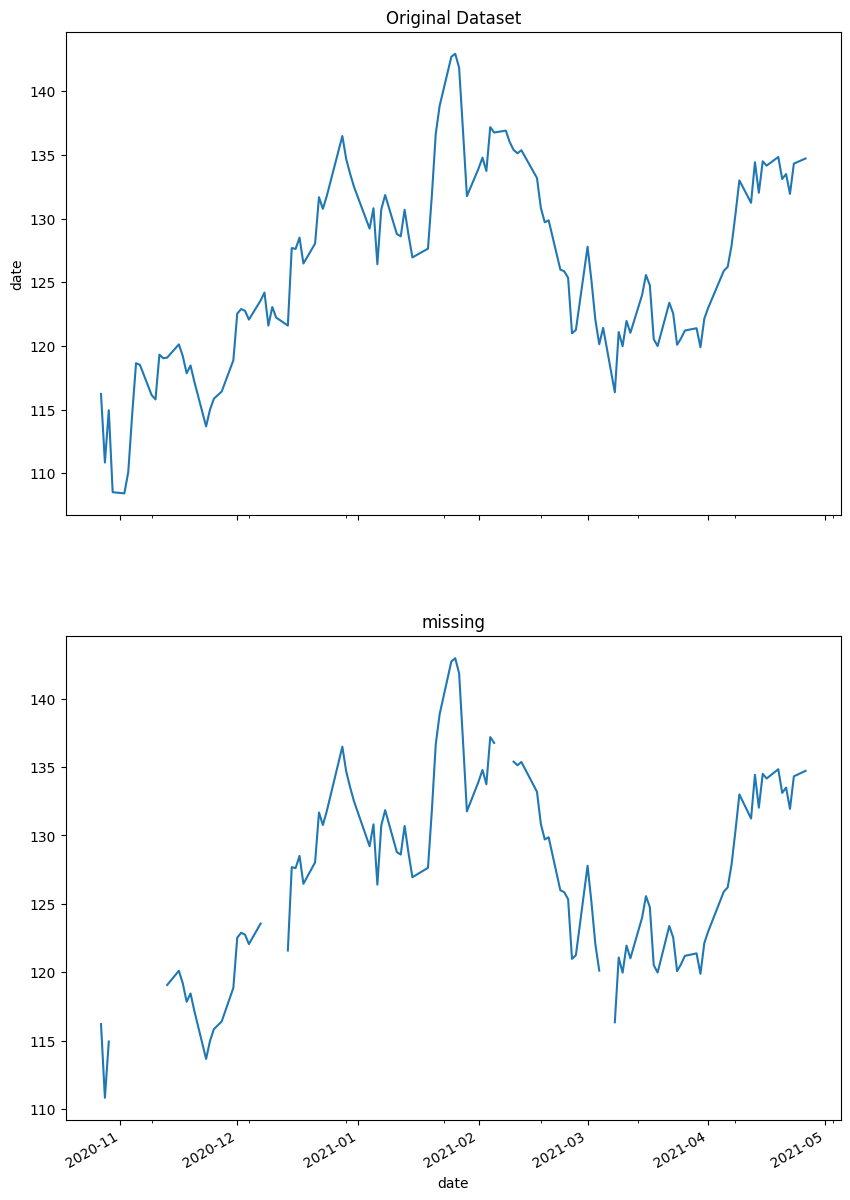

In [18]:
plot_dfs(apple_original, 
         apple_missing, 
         'close',
         title="AAPL Close Prices",
         xlabel="Dates",
         ylabel="date")

## Handling Missing Data with Univariate Imputation using pandas  

Some basic univariate imputation techniques include the following:
* Imputing using the mean.
* Imputing using the last observation forward (forward fill). This can be referred to as Last Observation Carried Forward (LOCF).
* Imputing using the next observation backward (backward fill). This can be referred to as Next Observation Carried Backward (NOCB).  

You will use two datasets to impute missing data using different techniques and then compare the results.

In [35]:
apple_missing['ffill'] = apple_missing['close'].fillna(method='ffill')
apple_missing['bfill'] = apple_missing['close'].fillna(method='bfill')
# apple_missing['mean'] = apple_missing['close'].fillna(method='mean')


/var/folders/85/5fry4xk160lfn0vlgt62q99m0000gn/T/ipykernel_82951/2608170368.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_missing['ffill'] = apple_missing['close'].fillna(method='ffill')
/var/folders/85/5fry4xk160lfn0vlgt62q99m0000gn/T/ipykernel_82951/2608170368.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_missing['bfill'] = apple_missing['close'].fillna(method='bfill')


In [31]:
apple_missing

,close,ffill,bfill
date,,,
2020-10-27,116.225510,116.225510,116.225510
2020-10-28,110.842850,110.842850,110.842850
2020-10-29,114.949615,114.949615,114.949615
2020-10-30,NaN,114.949615,117.853889
2020-11-02,NaN,114.949615,117.853889
...,...,...,...
2021-04-20,133.110001,133.110001,133.110001
2021-04-21,133.500000,133.500000,133.500000
2021-04-22,131.940002,131.940002,131.940002


In [32]:
_ = rmse_score(apple_original,apple_missing, 'close')

RMSE for ffill: 1.4044484723233992
RMSE for bfill: 1.575127067393878


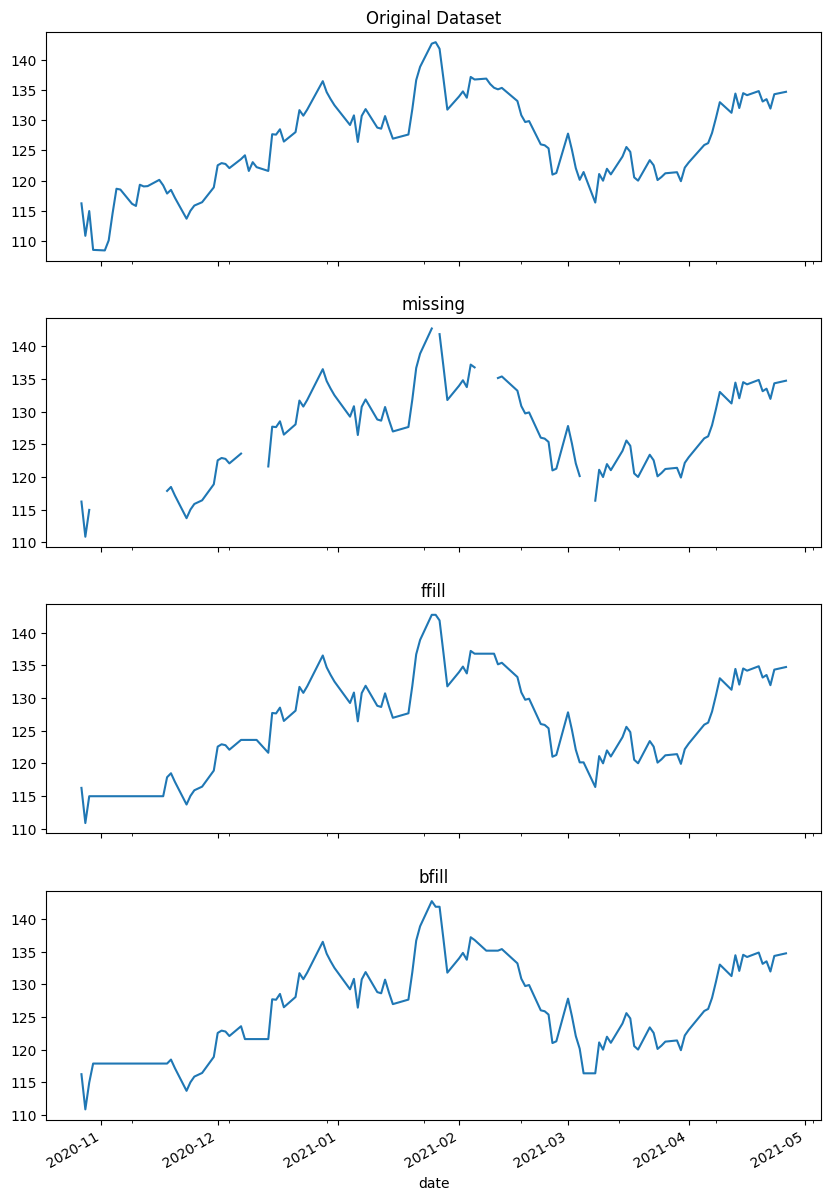

In [33]:
plot_dfs(apple_original, apple_missing, 'close')

### Handling Missing Data with Univariate Imputation using Scikit-Learn

* Using Sckit-Learn `SimpleImputer`

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [37]:
folder = Path('../data')
prices_original = read_dataset(folder, file='prices_original.csv', date_col=0)
apple_original = prices_original.loc[prices_original['ticker'] == 'AAPL'][['close']]

prices_missing = read_dataset(folder, file='prices_missing.csv', date_col=0)
apple_missing = prices_missing.loc[prices_missing['ticker'] == 'AAPL'][['close']]

Need to convert to NumPy array, so you will need to use the Series.values property followed by the .reshape(-1, 1) method to create a 2D NumPy array. Simply, what this is doing is transforming the 1D array from .values of shape (226, ) to a 2D array of shape (226, 1), which is a column vector:

In [39]:
apple_missing['close'].values[0:10]

array([116.22550964, 110.84284973, 114.94961548,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])

In [41]:
apple_missing['close'].values[0:10].reshape(-1,1)

array([[116.22550964],
       [110.84284973],
       [114.94961548],
       [         nan],
       [         nan],
       [         nan],
       [         nan],
       [         nan],
       [         nan],
       [         nan]])